In [99]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import warnings
from download_PurpleAir_data import *
import datetime
from meteostat import Point, Daily, Hourly, units, Stations
from geopy.geocoders import Nominatim
import numpy as np
import os
import statsHelper
from scipy.ndimage import median_filter
import statsmodels.api as sm
from matplotlib import pyplot as plt
from plotsHelper import *
from geoHelper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
# Initialize the Nominatim geocoder
geolocator = Nominatim(user_agent="city_latlong_app")

# Get location information for the specified city
city = "Davis"
location = geolocator.geocode(f"{city}, California")
radius = 10000 # Radius in meters

# Extract latitude and longitude
if location:
    city_latitude = location.latitude
    city_longitude = location.longitude
    print(f"City: {city}")
    print(f"Latitude: {city_latitude}")
    print(f"Longitude: {city_longitude}")
else:
    print(f"Could not find location for {city}")


City: Davis
Latitude: 38.5435526
Longitude: -121.739005


In [101]:
city = "Mountain View" #really Catherines house
city_latitude = 37.410631
city_longitude = -122.096883
radius = 500 # Radius in meters

In [102]:
sensors_df = get_purpleair_sensor_ids()

# Apply the filtering
sensors_df['within_radius'] = sensors_df.apply(
    lambda row: is_within_radius(row['latitude'], row['longitude'], city_latitude, city_longitude, radius),
    axis=1
)

# Filter the DataFrame
local_sensors_df = sensors_df[sensors_df['within_radius']]

# Drop the helper column
local_sensors_df = local_sensors_df.drop(columns=['within_radius'])
local_sensors_df.set_index('sensor_index', inplace=True)

display(local_sensors_df)


name  location_type  \
sensor_index                                                           
20601         Mountain View–Monta Loma (Snorlax nest)              0   
26931                                     living room              1   
46333                                      Monta Loma              0   
64451                                            Thea              0   
88953                                       515Emmons              1   
169149                                         touch2              1   
214959                                     Monta Loma              0   

              position_rating   latitude   longitude  altitude  confidence  
sensor_index                                                                
20601                       5  37.406940 -122.094315      37.0           0  
26931                       5  37.409206 -122.101210      30.0          30  
46333                       5  37.413128 -122.100880      21.0         100  
64451                       2  37.407887 -122.094380      34.0         100  
88953                       5  37.410645 -122.096560      27.0          30  
169149                      5  37.409130 -122.101330      30.0          30  
214959                      5  37.406530 -122.098335      38.0         100

In [103]:
start_time = datetime.datetime(2024, 6, 1, 0, 0)
end_time = datetime.datetime(2024, 8, 15, 0, 0) #accidentally added future times
t_res = 60 #minutes
start_stamp = start_time.timestamp() #1652156890
end_stamp = end_time.timestamp() #1675238400
path = f'./Data/{city}'
if os.path.exists(path) == False:
    os.makedirs(path)
sensors_data = {}
overwrite = False
for sensor_id in local_sensors_df.index.values:
    #check if the file exists
    name = f"{data_name(sensor_id, start_stamp, end_stamp)}.parquet"
    if os.path.exists(f"{path}/{name}") == False or overwrite:
        print(f"Fetching data for sensor {sensor_id}")
        fetch_purpleair_data(
            sensor_ids = [sensor_id],
            start_stamp = start_stamp,
            end_stamp = end_stamp,
            path = path
        )


In [104]:
for i, sensor_id in enumerate(local_sensors_df.index.values):
    name = f"{data_name(sensor_id, start_stamp, end_stamp)}.parquet"
    df = pd.read_parquet(f"{path}/{name}")
    df["time"] = pd.to_datetime(df["time_stamp"], unit='s', utc=True)
    df["time"] = df["time"].dt.tz_convert('US/Pacific')
    df.set_index("time", inplace=True)
    if df["temperature"].dtype != float:
        warnings.warn(f"Sensor {sensor_id} does not contain temperature data and will be dropped")
        local_sensors_df.drop(index = sensor_id, inplace = True)
        continue
    df["temperature"] = df["temperature"].map(lambda x: (x - 32) * 5/9) # To Celcius
    df = pd.DataFrame(median_filter(df, size=5, axes = 0), index = df.index, columns = df.columns)
    df = df.resample(f"{t_res}min", origin="start_day").mean()#.interpolate()
    if df.isna().sum()["temperature"] > 2*24*60/t_res:
        warnings.warn(f"Sensor {sensor_id} has missing temperature data and will be dropped")
        local_sensors_df.drop(index = sensor_id, inplace = True)
        continue
    df = df.interpolate()
    if i == 0:
        index = df.index
    else:
        try:
            df = df.loc[index]
        except:
            warnings.warn(f"Sensor {sensor_id} does not have the same time index as the first sensor and will be dropped")
            local_sensors_df.drop(index = sensor_id, inplace = True)
            continue
    sensors_data[sensor_id] = df.T

sensors_data = pd.concat(sensors_data, axis=0).T


In [105]:
stations = Stations()
stations = stations.inventory('hourly', start_time)
stations = stations.nearby(city_latitude, city_longitude)
station = stations.fetch(1)
print(station["name"])

# print(station)

meteo_data = Hourly(station, start_time, end_time)

meteo_data = meteo_data.fetch()
meteo_data["wspd"] *= 0.277778 # Convert to m/s
meteo_data.index = meteo_data.index.tz_localize('UTC') # identify default timezone
meteo_data.index = meteo_data.index.tz_convert('US/Pacific') # convert to local time
meteo_data = meteo_data.resample(f"{t_res}min", origin="start_day").mean().interpolate()
meteo_data = meteo_data.loc[index]



id
74509    Moffett Field
Name: name, dtype: object


In [106]:
filtered_data = sensors_data.copy()
smooth_data = lambda x: statsHelper.smoothing_spline_ts(x, s_scale=0.4, plot=False)
smooth_fieds = ["temperature", "humidity"]
filtered_data.loc[:, (slice(None), smooth_fieds)] = filtered_data.loc[:, (slice(None), smooth_fieds)].apply(smooth_data)

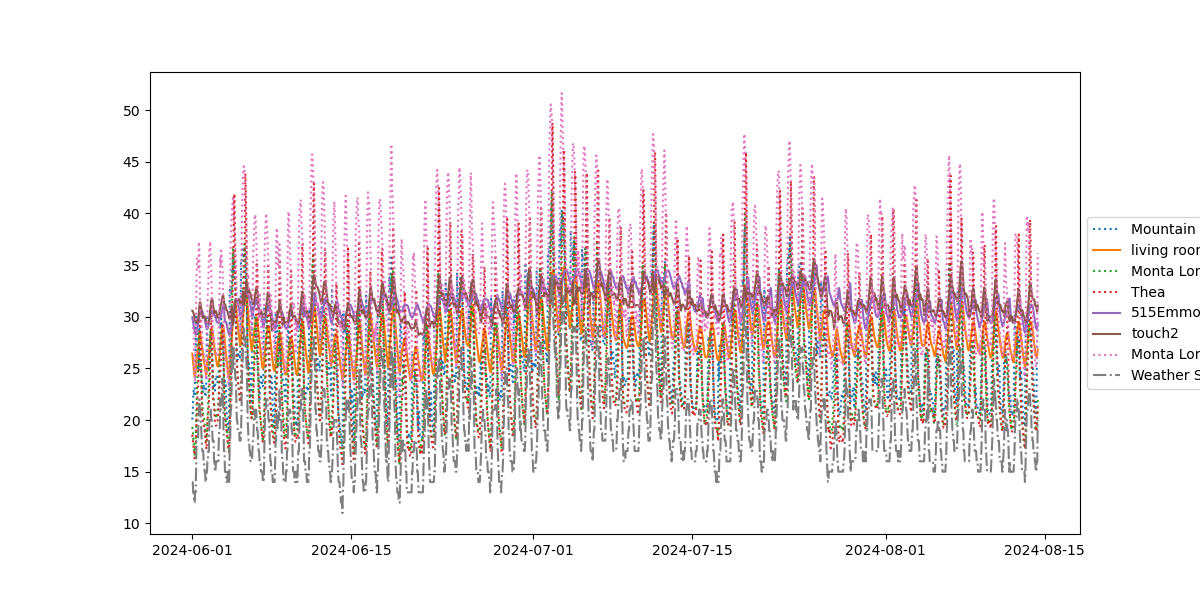

In [107]:
plt.figure(figsize=(12, 6))
linestyles = [':', '-']
for sensor_id in filtered_data.columns.levels[0]:
    df = filtered_data[sensor_id]
    name = local_sensors_df.loc[sensor_id]['name']
    linestyle = linestyles[local_sensors_df.loc[sensor_id]['location_type']]
    plt.plot(df["temperature"], linestyle=linestyle, label=name)
plt.plot(meteo_data.index, meteo_data["temp"], label="Weather Station", linestyle='-.')
#legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

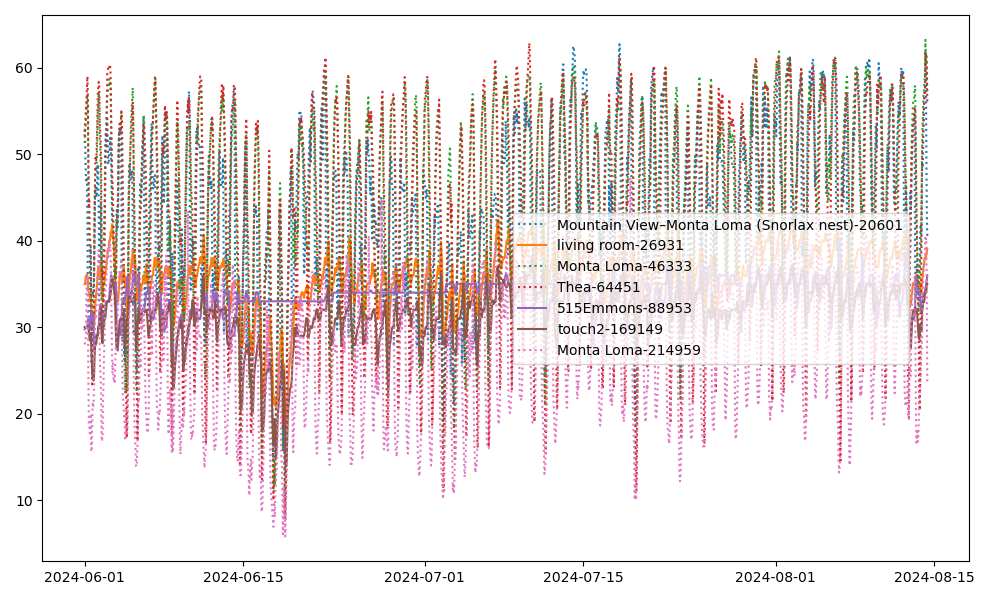

In [108]:
plt.figure(figsize=(10, 6))
linestyles = [':', '-']
for sensor_id in filtered_data.columns.levels[0]:
    df = filtered_data[sensor_id]
    name = local_sensors_df.loc[sensor_id]['name']
    linestyle = linestyles[local_sensors_df.loc[sensor_id]['location_type']]
    plt.plot(df["humidity"], linestyle=linestyle, label=f"{name}-{sensor_id}")
#legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(.5, .5))
plt.tight_layout()

## Markov Switching

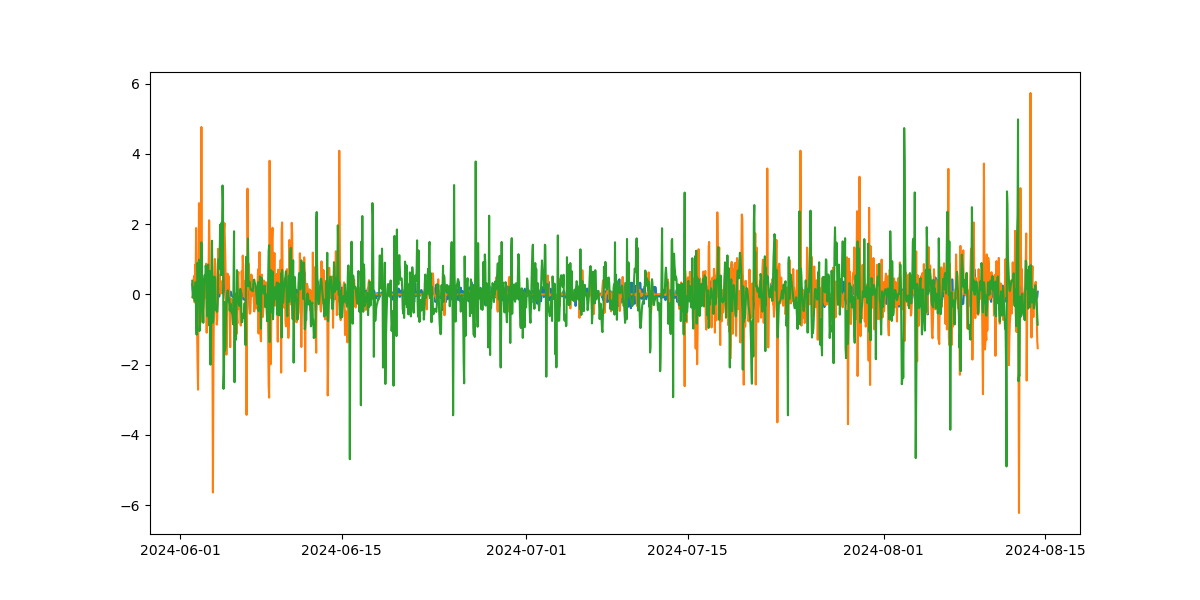

In [109]:
y_id = 88953
# y_id = 88057
out_id = find_closest_rows(local_sensors_df, y_id)[0]

y_og = filtered_data.loc[:, (y_id, "temperature")]
points_per_day = 24*60//t_res
y = y_og.copy() #np.log(y_og)
# y = (y - np.mean(y))# / np.std(y)
y.name = "temperature"

X_out = filtered_data.loc[:, (out_id, "temperature")]
X_og = filtered_data.loc[:, (y_id, ["humidity"])]
X_og.columns = X_og.columns.droplevel(0)
X_og = pd.concat([X_og, X_out], axis="columns")
X = X_og.copy()

# period = 24 * 60 * 60 * 10**9  # e.g., seconds with daily period
# X['sin_seasonal'] = np.sin(2 * np.pi * X.index.astype("int64") / period)
# X['cos_seasonal'] = np.cos(2 * np.pi * X.index.astype("int64")/ period)
# X['sin_2seasonal'] = np.sin(4 * np.pi * X.index.astype("int64") / period)
# X['cos_2seasonal'] = np.cos(4 * np.pi * X.index.astype("int64")/ period)
# X = (X - np.mean(X, axis="index")) / np.std(X, axis="index")

y = y.diff().diff(periods=points_per_day)
X = X.diff().diff(periods=points_per_day)

y = y.dropna()
X = X.dropna()

plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label="y Normalized")
plt.plot(X.index, X, label="X Normalized")


                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 1761
Model:               SARIMAX(2, 0, 2)   Log Likelihood                1135.125
Date:                Wed, 21 Aug 2024   AIC                          -2256.249
Time:                        17:47:24   BIC                          -2217.934
Sample:                    06-02-2024   HQIC                         -2242.090
                         - 08-14-2024                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
humidity                   0.0266      0.003      9.555      0.000       0.021       0.032
(64451, 'temperature')     0.0046      0.004      1.269      0.205      -0.002       0.012
ar.L

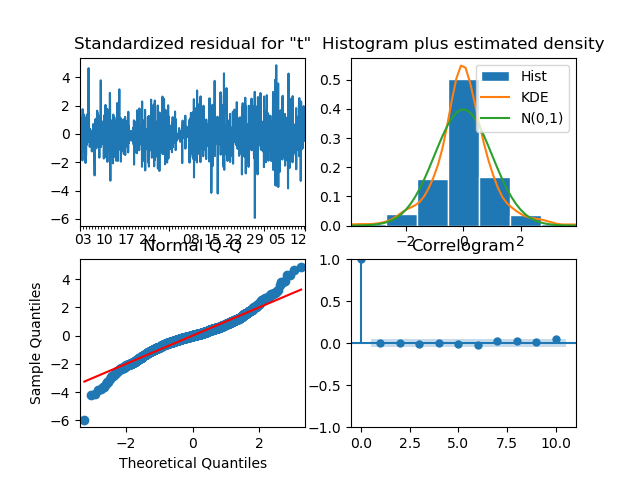

In [110]:


# Define the state-space model
model = sm.tsa.SARIMAX(
    endog=y, 
    exog=X, 
    order=(2, 0, 2),  # AR(1) process
    seasonal_order=(0, 0, 0, 0),  # No seasonal component
    trend='n'  # Include a constant trend
)

# Fit the model
results = model.fit(disp=False)

# Summary of the results
print(results.summary())

# Plot the filtered states (estimated hidden states)
results.plot_diagnostics()
plt.show()

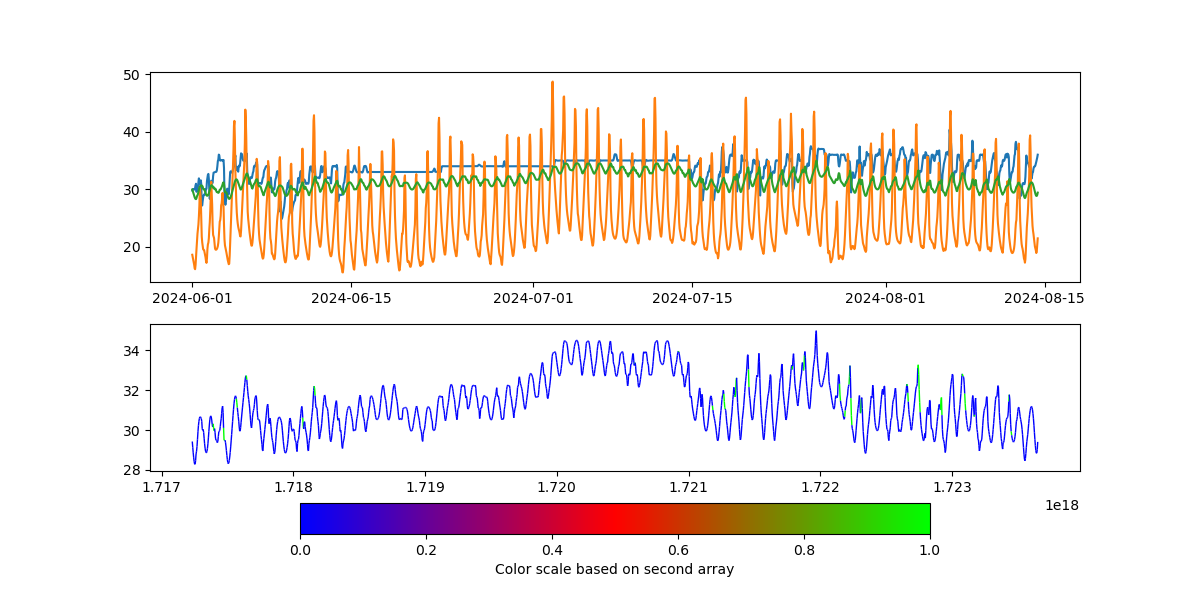

In [119]:
order = 2
# model = sm.tsa.MarkovAutoregression(endog=y, k_regimes=2, order=order, trend='n', exog=X.values, switching_ar=False, switching_exog=True, switching_variance=False)
model = sm.tsa.MarkovRegression(endog=y, k_regimes=2, order=order, trend='n', exog=X, switching_exog=True, switching_variance=False)
fitted_model = model.fit()
fitted_model.summary()
fig, axs = plt.subplots(2, figsize=(12, 6))
axs[0].plot(X_og.index, X_og, label="Temperature")
axs[0].plot(y_og.index, y_og, label="Sensor")

likely_states = np.argmax(fitted_model.filtered_marginal_probabilities, axis=1)
y_plot = y_og.iloc[order:]
fig, axs[0] = plot_colored_line(fig, axs[1], y_plot, likely_states)

# fig, axes = plt.subplots(1, figsize=(7, 7))
# ax = axes
# ax.plot(fitted_model.filtered_marginal_probabilities)


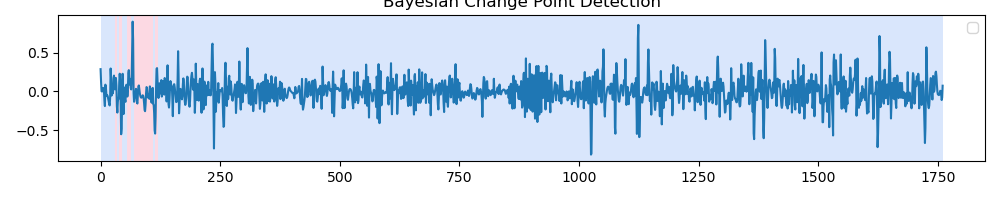

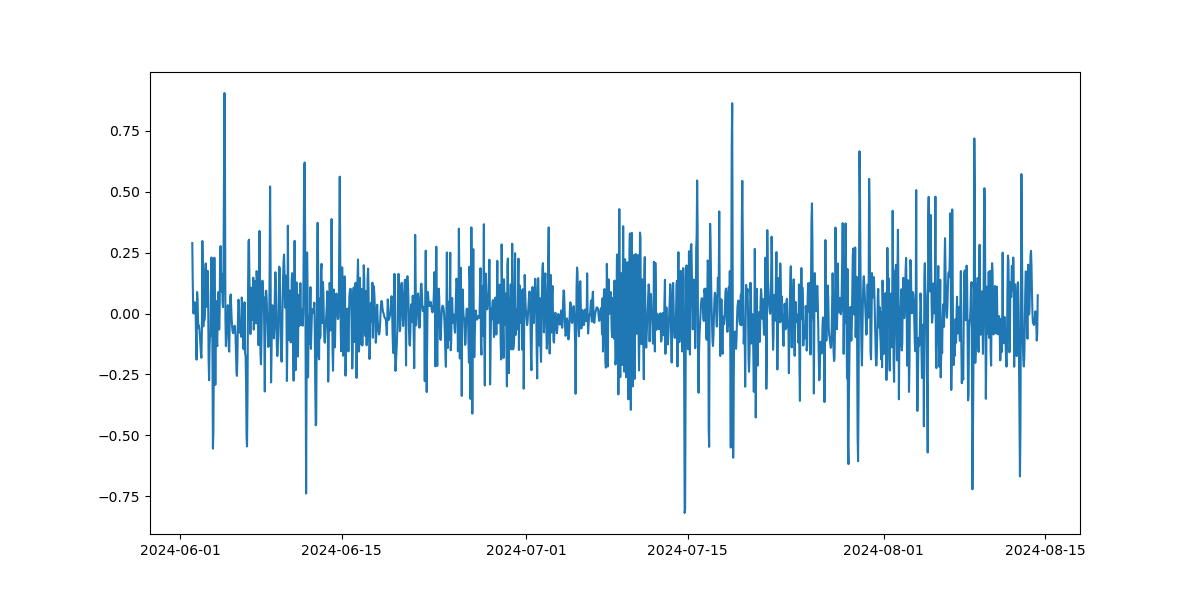

In [120]:
import ruptures as rpt
import matplotlib.pyplot as plt

# Assuming y is your time series
# Run the Bayesian change point detection
yX = pd.concat([y, X], axis="columns")
model = rpt.Binseg(model="l2").fit(yX.values)
breakpoints = model.predict(n_bkps=10)  # Choose number of breakpoints

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y, label="Observed Data")
rpt.display(y, breakpoints)
plt.title("Bayesian Change Point Detection")
plt.legend()
plt.show()

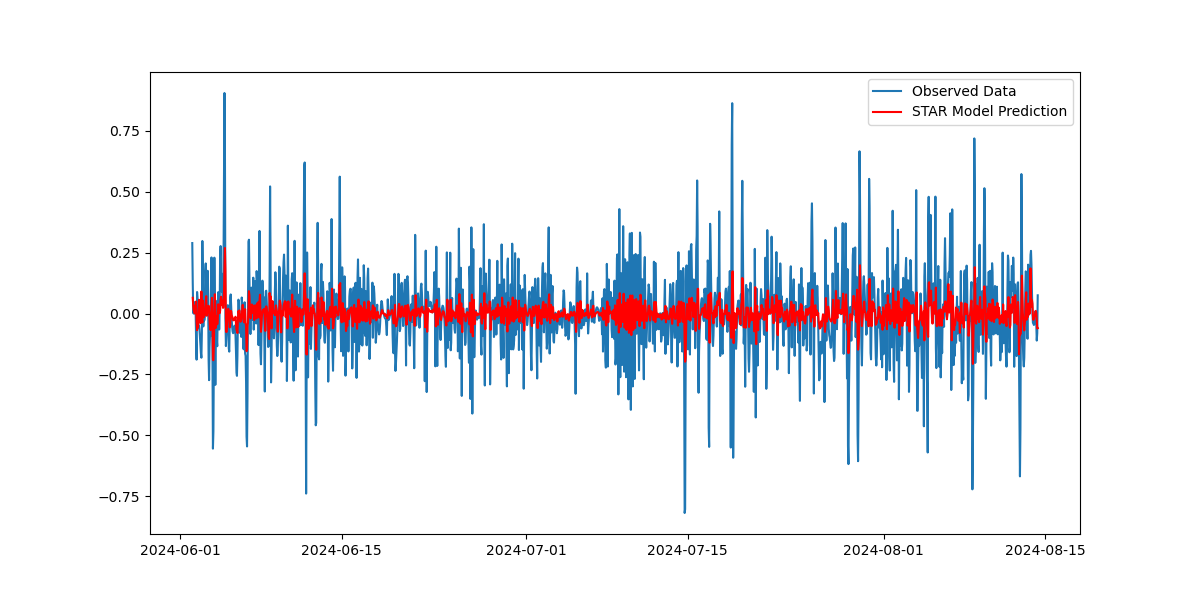

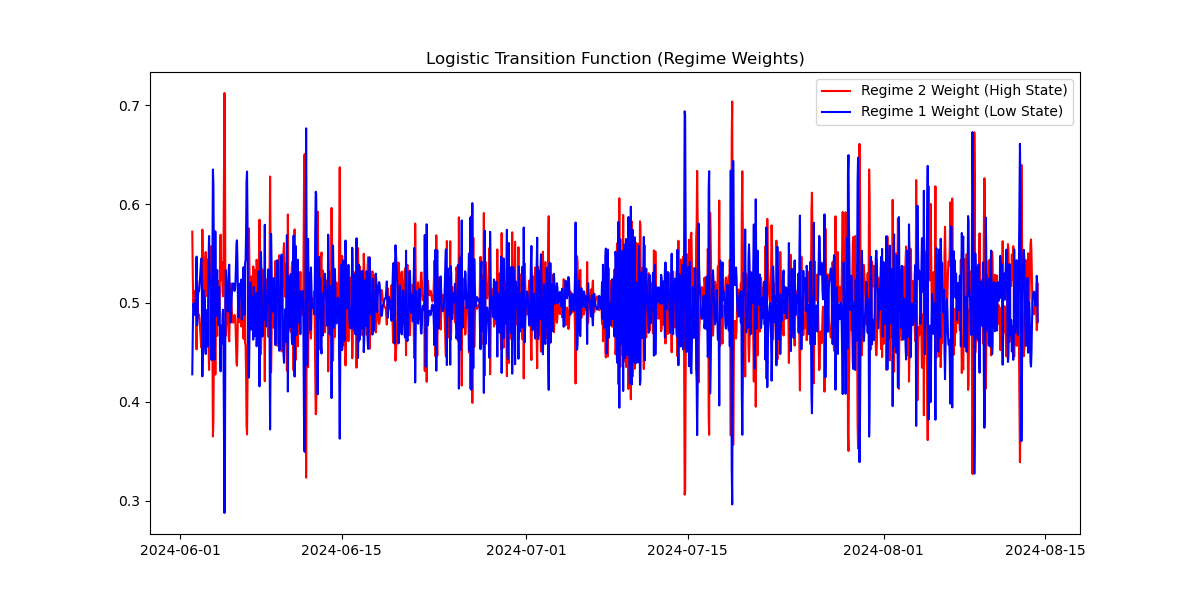

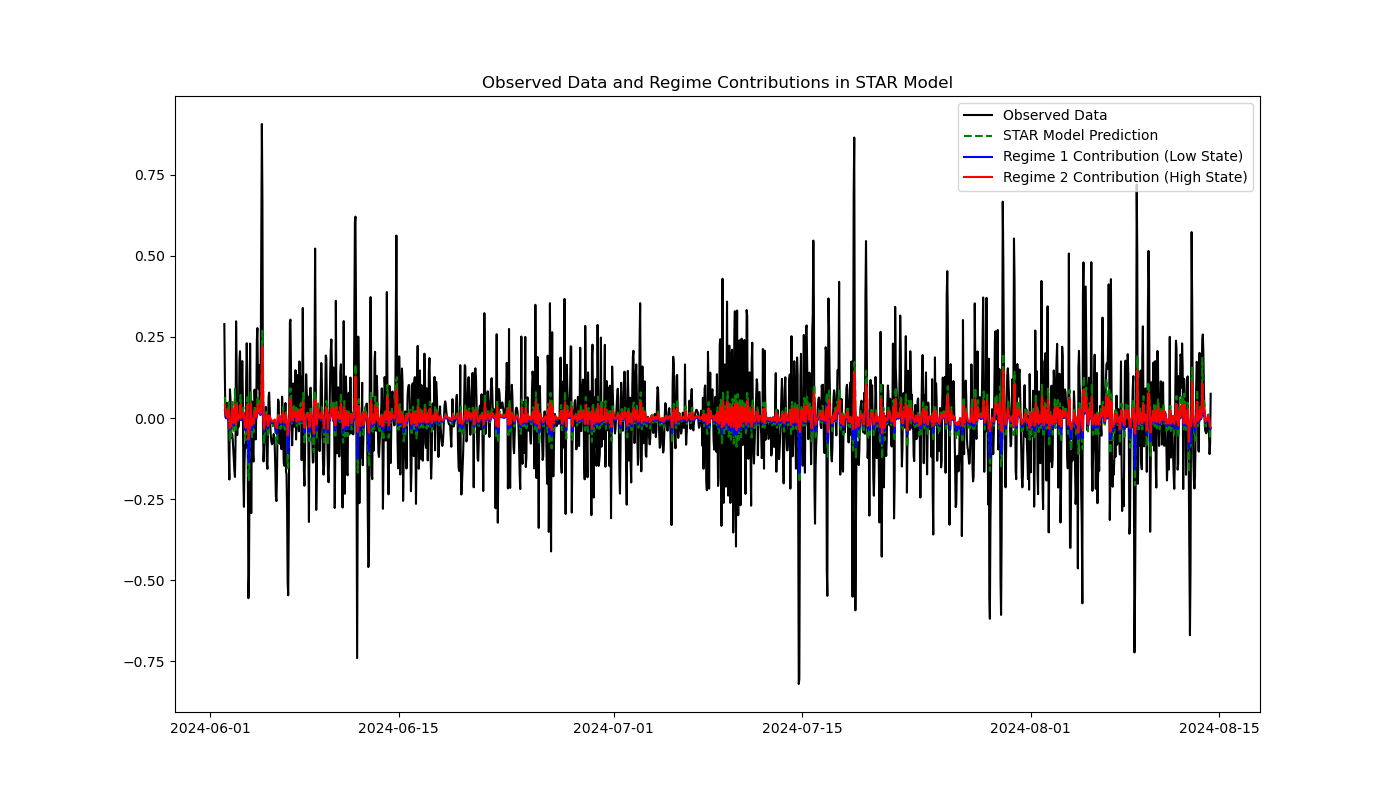

In [121]:
from statsmodels.tsa.ar_model import AutoReg

# Assuming y and X are your time series and exogenous variables
transition_var = y  # Use temperature or another variable as the transition variable

# Define the logistic transition function
def logistic_transition(x, gamma, c):
    return 1 / (1 + np.exp(-gamma * (x - c)))

# Choose gamma (smoothness) and c (threshold)
gamma = 1  # Higher gamma means sharper transition
c = np.median(transition_var)

# Create the transition variable
G = logistic_transition(transition_var, gamma, c)

# Fit two separate autoregressive models for each regime
model_low = AutoReg(y * (1 - G), lags=1, exog=X).fit()
model_high = AutoReg(y * G, lags=1, exog=X).fit()

# Combined model predictions
y_pred = (1 - G) * model_low.fittedvalues + G * model_high.fittedvalues

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y, label="Observed Data")
plt.plot(y_pred, label="STAR Model Prediction", color='red')
plt.legend()
plt.show()

# Plot the transition function (regime weights)
plt.figure(figsize=(12, 6))
plt.plot(G, label='Regime 2 Weight (High State)', color='red')
plt.plot(1 - G, label='Regime 1 Weight (Low State)', color='blue')
plt.title('Logistic Transition Function (Regime Weights)')
plt.legend()
plt.show()

# Contributions of each regime to the predicted values
y_pred_low = (1 - G) * model_low.fittedvalues
y_pred_high = G * model_high.fittedvalues

# Plot the original series and the contributions from each regime
plt.figure(figsize=(14, 8))
plt.plot(y, label='Observed Data', color='black')
plt.plot(y_pred, label='STAR Model Prediction', color='green', linestyle='--')
plt.plot(y_pred_low, label='Regime 1 Contribution (Low State)', color='blue')
plt.plot(y_pred_high, label='Regime 2 Contribution (High State)', color='red')
plt.title('Observed Data and Regime Contributions in STAR Model')
plt.legend()
plt.show()

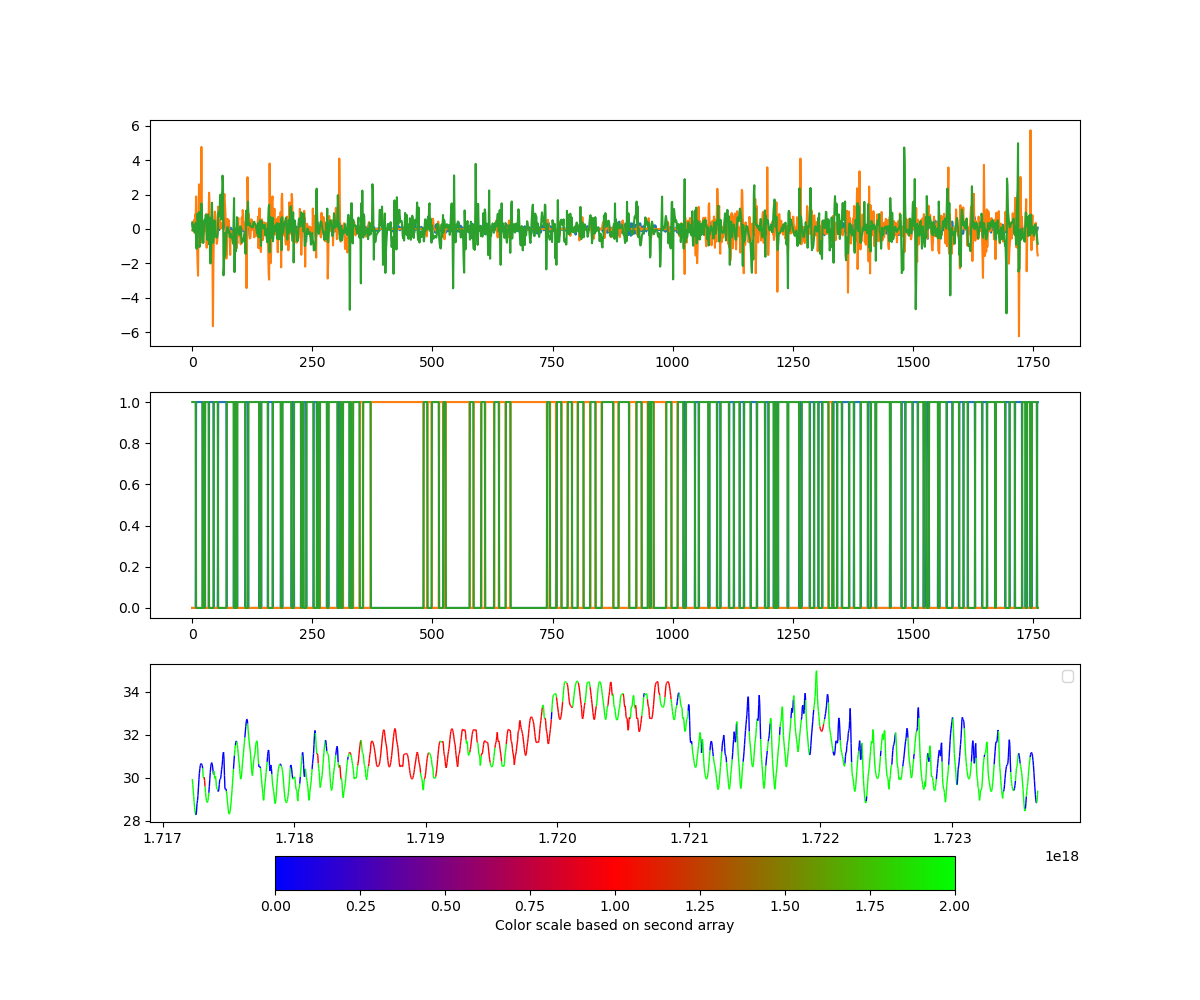

In [123]:

from hmmlearn.hmm import GaussianHMM

# Assuming y and X are your time series and exogenous variables
yX = pd.concat([y, X], axis="columns")
y_val = yX.values#.reshape(-1, 1)  # Reshape for HMM (required 2D array)

# Initialize HMM model
n_states = 3  # Adjust number of hidden states based on your analysis
hmm_model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)

# Fit model to the data
hmm_model.fit(y_val)

# Predict the hidden states
hidden_states = hmm_model.predict(y_val)

# Plotting the results
fig, ax = plt.subplots(3, figsize=(12, 10))
ax[0].plot(y_val, label="Observed Data")
for i in range(n_states):
    ax[1].plot(hidden_states == i, label=f"State {i+1}")
plt.legend()

_, ax[2] = plot_colored_line(fig, ax[2], y_og, hidden_states)